In [1]:
%matplotlib inline
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr
from typing import Tuple, Optional, Callable, Any

import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from typing import Optional, List

/Users/noahberner/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
class RegressiveModel(ABC):
    """
    This is a base class for various implementations of multi-variate models - models predicting time series
    from one or several time series. It also allows to do ensembling.

    TODO: Extend this to a "DynamicRegressiveModel" class, which acts on List[List[TimeSeries]].
    TODO: The first List[] would contain time-sliding lists of time series, letting the model
    TODO: be able to learn how to change weights over time. When len() of outer List[] is 0 it's a particular case
    """

    @abstractmethod
    def __init__(self):
        # Stores training date information:
        self.train_features: List[TimeSeries] = None
        self.train_target: TimeSeries = None

        # state
        self._fit_called = False

    @abstractmethod
    def fit(self, train_features: List[TimeSeries], train_target: TimeSeries) -> None:
        assert len(train_features) > 0, 'Need at least one feature series'
        assert all([s.has_same_time_as(train_target) for s in train_features]), 'All provided time series must ' \
                                                                                'have the same time index'
        self.train_features = train_features
        self.train_target = train_target
        self._fit_called = True

    @abstractmethod
    def predict(self, features: List[TimeSeries], n: int) -> TimeSeries:
        """
        :return: A TimeSeries containing the prediction obtained from [features], of same length as [features]
        """
        assert self._fit_called, 'fit() must be called before predict()'
        assert len(features) == len(self.train_features), 'Provided features must have same dimensionality as ' \
                                                          'training features. There were {} training features and ' \
                                                          'the function has been called with {} features' \
                                                          .format(len(self.train_features), len(features))

    def residuals(self) -> TimeSeries:
        """
        :return: a time series of residuals (absolute errors of the model on the training set)
        """
        assert self._fit_called, 'fit() must be called before residuals()'

        train_pred = self.predict(self.train_features)
        return abs(train_pred - self.train_target)


In [3]:
from sklearn.ensemble import RandomForestRegressor

class RF(RegressiveModel):
    
    
    def __init__(self, train_n_points):
        
        super().__init__()
        self.train_n_points = train_n_points
        self.regr = RandomForestRegressor()
        
    @staticmethod
    def _get_features_matrix_from_series(features: List[TimeSeries]):
        return np.array([s.values() for s in features]).T  # (n_samples x n_features)

    def fit(self, train_features: List[TimeSeries], train_target: TimeSeries):
        # Get (at most) the last [train_n_points] of each series
        last_train_ts = train_features[0].end_time()
        last_n_points_features = [s.slice_n_points_before(last_train_ts, self.train_n_points) for s in train_features]
        last_n_points_target = train_target.slice_n_points_before(last_train_ts, self.train_n_points)

        super().fit(last_n_points_features, last_n_points_target)

        self.regr.fit(self._get_features_matrix_from_series(last_n_points_features), last_n_points_target.values())

    def predict(self, features: List[TimeSeries], n:int):
        super().predict(features, n)
        y = self.regr.predict(self._get_features_matrix_from_series(features))
        return TimeSeries(pd.Series(y, index=features[0].time_index()))


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX


class reg_VARMAX(RegressiveModel):
    
    def __init__(self, train_n_points):
        
        super().__init__()
        self.training_series: TimeSeries = None
        self.train_n_points = train_n_points
        self.model = None
        self.model_fit = None
        
    @staticmethod
    def _get_features_matrix_from_series(features: List[TimeSeries]):
        return np.array([s.values() for s in features]).T  # (n_samples x n_features)
    
    @staticmethod
    def _convert_list_from_TS_to_pandas(features: List[TimeSeries]):
        converted = []
        for i in range(len(features)) :
            converted.append(features[i].pd_series()) 
        return converted
    
    def _convert_list_from_pands_to_TS(features: List[TimeSeries]):
        converted = []
        for i in range(len(features)) : 
            converted.append(features[i].pd_series()) 
        return converted

    def fit(self, train_features: List[TimeSeries], train_target: TimeSeries):
        # Get (at most) the last [train_n_points] of each series
        self.training_series = train_target
        features = train_features + [train_target]
        last_train_ts = train_features[0].end_time()
        last_n_points_features = [s.slice_n_points_before(last_train_ts, self.train_n_points) for s in features]
        last_n_points_target = train_target.slice_n_points_before(last_train_ts, self.train_n_points)
        
        super().fit(last_n_points_features, last_n_points_target)
        feat_matrix = self._get_features_matrix_from_series(last_n_points_features)
        self.model = VARMAX(endog=feat_matrix, order=(12, 12))
        self.model_fit = self.model.fit(disp=True)

    def _generate_new_dates(self, n: int):
        """
        Generate n new dates after the end of the training set
        """
        new_dates = [self.training_series.time_index()[-1] + (i * self.training_series.freq()) for i in range(1, n+1)]
        return pd.DatetimeIndex(new_dates, freq=self.training_series.freq_str())
    
    def predict(self, features: List[TimeSeries], n:int):
        super().predict(features, n)
        
        yhat = self.model.forecast(steps=n)
        print('yhat: ' + str(yhat))
        return TimeSeries(pd.Series(yhat, index=self._generate_new_dates(n)))

In [5]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima import auto_arima

class reg_ARIMA(RegressiveModel):
    def __init__(self, train_n_points, start_p=1, max_p=12, start_q=0, max_q=12, max_P=2, max_Q=2, start_P=1, start_Q=1,
                 start_d=0, max_d=2, max_D=1, max_order=30, seasonal=True, stepwise=True, approximation=False,
                 error_action='ignore', trace=False, suppress_warnings=True):

        super().__init__()
        self.training_series: TimeSeries = None
        self.train_n_points = train_n_points
        self.start_p = start_p
        self.max_p = max_p
        self.start_q = start_q
        self.max_q = max_q
        self.max_P = max_P
        self.max_Q = max_Q
        self.start_P = start_P
        self.start_Q = start_Q
        self.start_d = start_d
        self.max_d = max_d
        self.max_D = max_D
        self.max_order = max_order
        self.seasonal = seasonal
        self.stepwise = stepwise
        self.approximation = approximation
        self.error_action = error_action
        self.trace = trace
        self.suppress_warnings = suppress_warnings
        self.model = None

    @staticmethod
    def _get_features_matrix_from_series(features: List[TimeSeries]):
        return np.array([s.values() for s in features]).T  # (n_samples x n_features)
    
    def __str__(self):
        return 'auto-ARIMA'
    
    def _build_forecast_series(self, points_preds: np.ndarray,
                               lower_bound: Optional[np.ndarray] = None,
                               upper_bound: Optional[np.ndarray] = None):

        time_index = self._generate_new_dates(len(points_preds))

        return TimeSeries.from_times_and_values(time_index, points_preds, lower_bound, upper_bound)
     
    def _generate_new_dates(self, n: int):
        """
        Generate n new dates after the end of the training set
        """
        new_dates = [self.training_series.time_index()[-1] + (i * self.training_series.freq()) for i in range(1, n+1)]
        return pd.DatetimeIndex(new_dates, freq=self.training_series.freq_str())
    
    def fit(self, train_features: List[TimeSeries], train_target: TimeSeries):
        # Get (at most) the last [train_n_points] of each series
        self.training_series = train_target
        last_train_ts = train_features[0].end_time()
        last_n_points_features = [s.slice_n_points_before(last_train_ts, self.train_n_points) for s in train_features]
        last_n_points_target = train_target.slice_n_points_before(last_train_ts, self.train_n_points)
        super().fit(last_n_points_features, last_n_points_target)
        exog1 = self._get_features_matrix_from_series(last_n_points_features)
        self.model = auto_arima(last_n_points_target.values(),
                                start_p=self.start_p,
                                max_p=self.max_p,
                                start_q=self.start_q,
                                max_q=self.max_q,
                                max_P=self.max_P,
                                max_Q=self.max_Q,
                                start_P=self.start_P,
                                start_Q=self.start_Q,
                                start_d=self.start_d,
                                max_d=self.max_d,
                                max_D=self.max_D,
                                max_order=self.max_order,
                                seasonal=self.seasonal,
                                stepwise=self.stepwise,
                                approximation=self.approximation,
                                error_action=self.error_action,
                                trace=self.trace,
                                suppress_warnings=self.suppress_warnings)

    def predict(self, features: List[TimeSeries], n:int):
        super().predict(features, n)
        forecast = self.model.predict(n_periods=n)
        return self._build_forecast_series(forecast)

In [6]:
import fbprophet

class reg_Prohpet(RegressiveModel):
    def __init__(self, train_n_points, weekly_seasonality=False, daily_seasonality=False, country_holidays: str=None):

        self.training_series: TimeSeries = None
        self.train_n_points = train_n_points
        super().__init__()

        self.country_holidays = country_holidays
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.model = None

    @staticmethod
    def _get_features_matrix_from_series(features: List[TimeSeries]):
        return np.array([s.values() for s in features]).T  # (n_samples x n_features)
    
    def __str__(self):
        return 'Prophet'
    
    def _build_forecast_series(self, points_preds: np.ndarray,
                               lower_bound: Optional[np.ndarray] = None,
                               upper_bound: Optional[np.ndarray] = None):

        time_index = self._generate_new_dates(len(points_preds))

        return TimeSeries.from_times_and_values(time_index, points_preds, lower_bound, upper_bound)
     
    def _generate_new_dates(self, n: int):
        """
        Generate n new dates after the end of the training set
        """
        new_dates = [self.training_series.time_index()[-1] + (i * self.training_series.freq()) for i in range(1, n+1)]
        return pd.DatetimeIndex(new_dates, freq=self.training_series.freq_str())
    
    def fit(self, train_features: List[TimeSeries], train_target: TimeSeries):
        # Get (at most) the last [train_n_points] of each series
        self.training_series = train_target
        
        last_train_ts = train_features[0].end_time()
        last_n_points_features = [s.slice_n_points_before(last_train_ts, self.train_n_points) for s in train_features]
        last_n_points_target = train_target.slice_n_points_before(last_train_ts, self.train_n_points)
        super().fit(last_n_points_features, last_n_points_target)

        in_df = pd.DataFrame(data={
            'ds': last_n_points_target.time_index(),
            'y': last_n_points_target.values()
        })

        # TODO: user-provided seasonalities, or "auto" based on stepduration
        self.model = fbprophet.Prophet(weekly_seasonality=self.weekly_seasonality,
                                       daily_seasonality=self.daily_seasonality)

        # Input built-in country holidays
        if self.country_holidays is not None:
            self.model.add_country_holidays(self.country_holidays)

        self.model.fit(in_df)
    

    def predict(self, features: List[TimeSeries], n:int):
        super().predict(features, n)
        new_dates = self._generate_new_dates(n)
        new_dates_df = pd.DataFrame(data={'ds': new_dates})

        predictions = self.model.predict(new_dates_df)

        forecast = predictions['yhat'][-n:].values
        conf_lo = predictions['yhat_lower'][-n:].values
        conf_hi = predictions['yhat_upper'][-n:].values
        return self._build_forecast_series(forecast, conf_lo, conf_hi)

# Task 5: Ensembling and Backtesting

**Task**: Create a **TimeSeries** from a pandas dataframe loading the retailNz dataset.

In [7]:
def get_train_val_series(in_train_features_series: List[TimeSeries], in_train_target_series: TimeSeries, in_val_series: TimeSeries, start: pd.Timestamp, nr_points_val: int,
                         nr_steps_iter: int = 1) -> List[Tuple[List[TimeSeries], TimeSeries, TimeSeries]]:
    """
    Returns a list of (training_set, validation_set) pairs for backtesting.

    This is the sliding window

    :param series: The full time series; needs to be split
    :param start: the start time of the earliest validation set
    :param nr_points_val: the number of points in the validation sets
    :param nr_steps_iter: the number of time steps to iterate between the successive validation sets
    :return: a list of (training_set, validation_set) pairs
    """

    assert start in in_train_target_series, 'The provided start timestamp is not in the time series.'
    assert start != in_train_target_series.end_time(), 'The provided start timestamp is the last timestamp of the time series'
    # TODO: maybe also check that valset_duration >= series frequency
    first_run: bool = True
    curr_val_start: pd.Timestamp = start
    curr_start_of_sliding_window: pd.Timestamp = in_train_target_series.start_time()
        
    def _get_train_val_and_increase_pointer() -> Tuple[List[TimeSeries], TimeSeries, TimeSeries]:
        nonlocal curr_val_start
        nonlocal curr_start_of_sliding_window
        nonlocal first_run
        
        out_train_features_series = [None] * len(in_train_features_series)
        out_prediction_features_series = [None] * nr_points_val
        for index in range(len(in_train_features_series)) : 
            #discard the data before the sliding window for the training data
            if first_run :
                sliding_window = in_train_features_series[index]
            else :
                sliding_window = in_train_features_series[index].drop_beginning(curr_start_of_sliding_window)
             
            #discard the data after the sliding window for the training data
            out_train_features_series[index], _ = sliding_window.split_after(curr_val_start)
                
                
        #discard the data before the sliding window for the training data
        if first_run :
            sliding_window = in_train_target_series
        else :
            sliding_window = in_train_target_series.drop_beginning(curr_start_of_sliding_window)

        #discard the data after the sliding window for the training data
        out_train_target_series, _ = sliding_window.split_after(curr_val_start)
                
        #split the data for validation
        _, out_val_series_all = in_val_series.split_after(curr_val_start)
        #drop the validation values after at most nr_points_val values
        out_val_series = out_val_series_all.slice_n_points_after(out_val_series_all.start_time(), nr_points_val)
        #move pointers fowards 
        increase = nr_steps_iter * in_train_target_series.freq()
        curr_val_start += increase
        if first_run : 
            first_run = False
        else :
            curr_start_of_sliding_window += increase
        return out_train_features_series, out_train_target_series, out_val_series
    
    series_pairs = []
    curr_train_features_series, curr_train_target_series, curr_val_series = _get_train_val_and_increase_pointer()

    while len(curr_val_series) >= nr_points_val:
        #print('curr_train_target_series: ' + str(curr_train_target_series))
        print('curr_val_series: ' + str(curr_val_series))
        print('-------------------------------------')
        series_pairs.append((curr_train_features_series, curr_train_target_series, curr_val_series))
        curr_train_features_series, curr_train_target_series, curr_val_series = _get_train_val_and_increase_pointer()

    return series_pairs

In [8]:
def backtest(model: RegressiveModel, train_val_series: List[Tuple[List[TimeSeries], TimeSeries, TimeSeries]],
                                  eval_fn: Callable[[TimeSeries, TimeSeries], Any]) -> List[Any]:
    """
    Returns a list of results obtained when calling [eval_fn] on the validation time series in [train_val_series] as
    well as on the corresponding prediction obtained from [model]

    TODO: option for point-prediction
    """

    results = []
    for train_features, train_target, val in train_val_series:
        model.fit(train_features, train_target)
        pred = model.predict(train_features, len(val))
        results.append(eval_fn(val, pred))
    return results

In [9]:
def backtest_model(model, train_features_series: List[TimeSeries], train_target_series: TimeSeries, val_series: TimeSeries, metric):
    tic = time.time()
    train_val_series = get_train_val_series(train_features_series, train_target_series, val_series, start=pd.Timestamp('20190101'), nr_points_val=12)
    res = backtest(model, train_val_series, metric)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

<bound method NDFrame.head of       Unnamed: 0        date  Close  total-reactions  reactions-like  \
0             62  2014-03-05  37.52          92787.0         92787.0   
1             63  2014-03-06  37.54         113202.0        113202.0   
2             64  2014-03-07  37.69         157877.0        157877.0   
3             65  2014-03-08  37.69         157877.0        157877.0   
4             66  2014-03-09  37.69         157877.0        157877.0   
...          ...         ...    ...              ...             ...   
2035        2097  2019-09-30  37.48           4760.0          4376.0   
2036        2098  2019-10-01  36.11          79882.0         75441.0   
2037        2099  2019-10-02  34.68          57282.0         52513.0   
2038        2100  2019-10-03  34.98          35572.0         25315.0   
2039        2101  2019-10-04  34.91          45884.0         39756.0   

      reactions_love  reactions-haha  reactions-wow  reactions-sad  \
0                0.0             0.

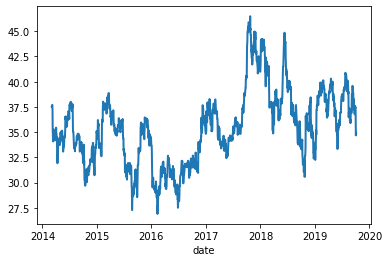

In [10]:
data_key = 'Close' # or 'Chemist' or 'Footwear'
#df = pd.read_csv('RetailNZ.csv', sep = ',')
df = pd.read_csv('dataset_ffill.csv', sep = ',')
print(df.head)
series = TimeSeries.from_dataframe(df, 'date', data_key) # we ca explicitely give what column contains values
external_variables = []
for column in df:
    if column != 'date' and column != 'Close' :
        external_variables.append(TimeSeries.from_dataframe(df, 'date', column))
print(len(external_variables))
series.plot(lw=2)

Initialize a series of models

In [11]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
model_ar = AutoArima()


In [12]:
train_data, val_data = series.split_after(pd.Timestamp('20190101'))

split_external_variables = []
for i in range(len(external_variables)) :
    temp, _ = external_variables[i].split_after(pd.Timestamp('20190101'))
    split_external_variables.append(temp)




INFO:numexpr.utils:NumExpr defaulting to 8 threads.


                value   conf_low  conf_high
2019-01-02  34.446980  32.184137  36.571819
2019-01-03  34.470404  32.404296  36.445924
2019-01-04  34.490863  32.319348  36.409126
2019-01-05  34.506893  32.569160  36.684560
2019-01-06  34.517126  32.411086  36.705148
...               ...        ...        ...
2019-12-28  26.086007  13.701381  38.563683
2019-12-29  26.100208  13.221062  38.523367
2019-12-30  26.119243  13.124382  38.883498
2019-12-31  26.141745  13.446053  38.620402
2020-01-01  26.166251  13.098267  38.613371

[365 rows x 3 columns]
Freq: D


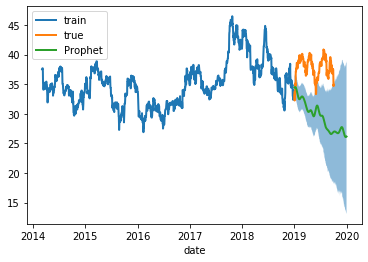

In [13]:
model_Prophet = reg_Prohpet(10000)
model_Prophet.fit(split_external_variables, train_data)
pred = model_Prophet.predict(split_external_variables, 365)
print(pred)

train_data.plot(lw=2, label='train')
val_data.plot(lw=2, label='true')

pred.plot(lw=2, label='Prophet')
plt.legend()

In [14]:
def sharpe(y_true, y_pred): # position, target returns
  ret = y_pred * y_true
  expected_ret = np.mean(ret)
  return - expected_ret / np.std(ret)

sharpe_Prophet = sharpe(val_data.pd_series(), pred.pd_series())
print('sharpe_Prophet: ' + str(sharpe_Prophet))

sharpe_Prophet: -12.00264686358815


                value
2019-01-02  33.549129
2019-01-03  33.553258
2019-01-04  33.557387
2019-01-05  33.561516
2019-01-06  33.565645
...               ...
2019-12-28  35.035578
2019-12-29  35.039707
2019-12-30  35.043836
2019-12-31  35.047965
2020-01-01  35.052094

[365 rows x 1 columns]
Freq: D


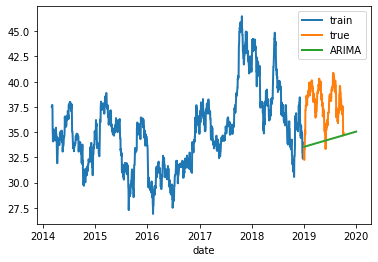

In [15]:
model_ARIMA = reg_ARIMA(1000)
model_ARIMA.fit(split_external_variables, train_data)
pred = model_ARIMA.predict(split_external_variables, 365)
print(pred)

train_data.plot(lw=2, label='train')
val_data.plot(lw=2, label='true')

pred.plot(lw=2, label='ARIMA')
plt.legend()

In [16]:
sharpe_ARIMA = sharpe(val_data.pd_series(), pred.pd_series())
print('sharpe_ARIMA: ' + str(sharpe_ARIMA))

sharpe_ARIMA: -22.18159472563466


In [17]:
models = [reg_Prohpet(10000), reg_ARIMA(10000)]
historical_regr_preds = []
for m in models :
    m.fit(split_external_variables, train_data)
    pred = m.predict(split_external_variables, 276)
    historical_regr_preds.append(pred)


In [18]:
regrModel = StandardRegressiveModel(train_n_points=10000)

series_val = val_data.intersect(historical_regr_preds[0])

print(historical_regr_preds[0])
print(series_val)

historical_pred = simulate_forecast_regr(historical_regr_preds, series_val, regrModel,
                                         pd.Timestamp('20190105'), fcast_horizon_n=270)

                value   conf_low  conf_high
2019-01-02  34.446980  32.273875  36.438668
2019-01-03  34.470404  32.399281  36.518376
2019-01-04  34.490863  32.415699  36.552169
2019-01-05  34.506893  32.404571  36.511662
2019-01-06  34.517126  32.342862  36.640124
...               ...        ...        ...
2019-09-30  26.901088  18.486178  36.124921
2019-10-01  26.924298  18.802166  35.704065
2019-10-02  26.945431  18.313616  36.167821
2019-10-03  26.964236  18.488682  35.684051
2019-10-04  26.980515  18.405545  36.408654

[276 rows x 3 columns]
Freq: D
            value
date             
2019-01-02  33.64
2019-01-03  32.25
2019-01-04  33.33
2019-01-05  33.33
2019-01-06  33.33
...           ...
2019-09-30  37.48
2019-10-01  36.11
2019-10-02  34.68
2019-10-03  34.98
2019-10-04  34.91

[276 rows x 1 columns]
Freq: D
...

MAPE Error Prophet: 22.644012433406306
MAPE Error auto-ARIMA: 5.533768099735903
MAPE Error ensemble: 60.77703087738112
sharpe_ENSEMBLE: -1.733422983933544


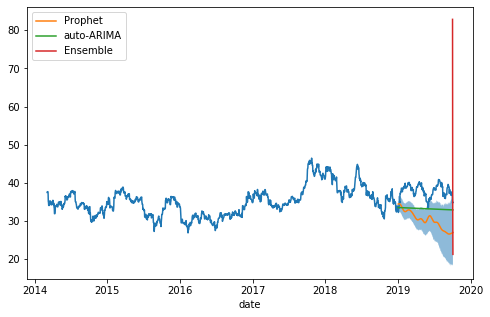

In [19]:
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_regr_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_regr_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

sharpe_ENSEMBLE = sharpe(val_data.pd_series(), historical_pred.pd_series())
print('sharpe_ENSEMBLE: ' + str(sharpe_ENSEMBLE))

In [20]:
print('series: ' + str(series))
print('-------------------------------------')
res_ARIMA = backtest_model(model_ARIMA, external_variables, series, series, mape)

print('res_ar: ' + str(res_ARIMA))

series:             value
date             
2014-03-05  37.52
2014-03-06  37.54
2014-03-07  37.69
2014-03-08  37.69
2014-03-09  37.69
...           ...
2019-09-30  37.48
2019-10-01  36.11
2019-10-02  34.68
2019-10-03  34.98
2019-10-04  34.91

[2040 rows x 1 columns]
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-01-02  33.64
2019-01-03  32.25
2019-01-04  33.33
2019-01-05  33.33
2019-01-06  33.33
2019-01-07  34.36
2019-01-08  34.81
2019-01-09  35.18
2019-01-10  34.73
2019-01-11  37.18
2019-01-12  37.18
2019-01-13  37.18
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-01-03  32.25
2019-01-04  33.33
2019-01-05  33.33
2019-01-06  33.33
2019-01-07  34.36
2019-01-08  34.81
2019-01-09  35.18
2019-01-10  34.73
2019-01-11  37.18
2019-01-12  37.18
2019-01-13  37.18
2019-01-14  37.66
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019

curr_val_series:             value
date             
2019-01-28  38.46
2019-01-29  38.47
2019-01-30  39.09
2019-01-31  39.02
2019-02-01  38.78
2019-02-02  38.78
2019-02-03  38.78
2019-02-04  38.93
2019-02-05  39.30
2019-02-06  39.91
2019-02-07  38.65
2019-02-08  38.70
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-01-29  38.47
2019-01-30  39.09
2019-01-31  39.02
2019-02-01  38.78
2019-02-02  38.78
2019-02-03  38.78
2019-02-04  38.93
2019-02-05  39.30
2019-02-06  39.91
2019-02-07  38.65
2019-02-08  38.70
2019-02-09  38.70
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-01-30  39.09
2019-01-31  39.02
2019-02-01  38.78
2019-02-02  38.78
2019-02-03  38.78
2019-02-04  38.93
2019-02-05  39.30
2019-02-06  39.91
2019-02-07  38.65
2019-02-08  38.70
2019-02-09  38.70
2019-02-10  38.70
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-02-24  39.99
2019-02-25  40.14
2019-02-26  40.11
2019-02-27  40.00
2019-02-28  39.48
2019-03-01  39.53
2019-03-02  39.53
2019-03-03  39.53
2019-03-04  39.25
2019-03-05  39.28
2019-03-06  38.67
2019-03-07  38.04
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-02-25  40.14
2019-02-26  40.11
2019-02-27  40.00
2019-02-28  39.48
2019-03-01  39.53
2019-03-02  39.53
2019-03-03  39.53
2019-03-04  39.25
2019-03-05  39.28
2019-03-06  38.67
2019-03-07  38.04
2019-03-08  37.99
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-02-26  40.11
2019-02-27  40.00
2019-02-28  39.48
2019-03-01  39.53
2019-03-02  39.53
2019-03-03  39.53
2019-03-04  39.25
2019-03-05  39.28
2019-03-06  38.67
2019-03-07  38.04
2019-03-08  37.99
2019-03-09  37.99
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-03-23  36.44
2019-03-24  36.44
2019-03-25  36.75
2019-03-26  36.87
2019-03-27  36.61
2019-03-28  37.06
2019-03-29  37.10
2019-03-30  37.10
2019-03-31  37.10
2019-04-01  37.76
2019-04-02  37.81
2019-04-03  38.39
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-03-24  36.44
2019-03-25  36.75
2019-03-26  36.87
2019-03-27  36.61
2019-03-28  37.06
2019-03-29  37.10
2019-03-30  37.10
2019-03-31  37.10
2019-04-01  37.76
2019-04-02  37.81
2019-04-03  38.39
2019-04-04  38.79
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-03-25  36.75
2019-03-26  36.87
2019-03-27  36.61
2019-03-28  37.06
2019-03-29  37.10
2019-03-30  37.10
2019-03-31  37.10
2019-04-01  37.76
2019-04-02  37.81
2019-04-03  38.39
2019-04-04  38.79
2019-04-05  38.94
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-04-19  39.90
2019-04-20  39.90
2019-04-21  39.90
2019-04-22  39.50
2019-04-23  39.83
2019-04-24  39.72
2019-04-25  39.11
2019-04-26  39.68
2019-04-27  39.68
2019-04-28  39.68
2019-04-29  40.01
2019-04-30  38.95
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-04-20  39.90
2019-04-21  39.90
2019-04-22  39.50
2019-04-23  39.83
2019-04-24  39.72
2019-04-25  39.11
2019-04-26  39.68
2019-04-27  39.68
2019-04-28  39.68
2019-04-29  40.01
2019-04-30  38.95
2019-05-01  38.75
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-04-21  39.90
2019-04-22  39.50
2019-04-23  39.83
2019-04-24  39.72
2019-04-25  39.11
2019-04-26  39.68
2019-04-27  39.68
2019-04-28  39.68
2019-04-29  40.01
2019-04-30  38.95
2019-05-01  38.75
2019-05-02  38.25
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:              value
date              
2019-05-16  37.380
2019-05-17  37.000
2019-05-18  37.000
2019-05-19  37.000
2019-05-20  36.970
2019-05-21  37.130
2019-05-22  35.550
2019-05-23  35.130
2019-05-24  35.120
2019-05-25  35.120
2019-05-26  35.120
2019-05-27  34.985
Freq: D
-------------------------------------
curr_val_series:              value
date              
2019-05-17  37.000
2019-05-18  37.000
2019-05-19  37.000
2019-05-20  36.970
2019-05-21  37.130
2019-05-22  35.550
2019-05-23  35.130
2019-05-24  35.120
2019-05-25  35.120
2019-05-26  35.120
2019-05-27  34.985
2019-05-28  34.850
Freq: D
-------------------------------------
curr_val_series:              value
date              
2019-05-18  37.000
2019-05-19  37.000
2019-05-20  36.970
2019-05-21  37.130
2019-05-22  35.550
2019-05-23  35.130
2019-05-24  35.120
2019-05-25  35.120
2019-05-26  35.120
2019-05-27  34.985
2019-05-28  34.850
2019-05-29  34.790
Freq: D
-------------------------------------
curr_val_seri

curr_val_series:             value
date             
2019-06-11  36.20
2019-06-12  35.67
2019-06-13  36.02
2019-06-14  35.66
2019-06-15  35.66
2019-06-16  35.66
2019-06-17  36.14
2019-06-18  36.70
2019-06-19  36.78
2019-06-20  36.96
2019-06-21  36.92
2019-06-22  36.92
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-06-12  35.67
2019-06-13  36.02
2019-06-14  35.66
2019-06-15  35.66
2019-06-16  35.66
2019-06-17  36.14
2019-06-18  36.70
2019-06-19  36.78
2019-06-20  36.96
2019-06-21  36.92
2019-06-22  36.92
2019-06-23  36.92
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-06-13  36.02
2019-06-14  35.66
2019-06-15  35.66
2019-06-16  35.66
2019-06-17  36.14
2019-06-18  36.70
2019-06-19  36.78
2019-06-20  36.96
2019-06-21  36.92
2019-06-22  36.92
2019-06-23  36.92
2019-06-24  36.96
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-07-08  38.23
2019-07-09  38.08
2019-07-10  38.10
2019-07-11  38.43
2019-07-12  39.21
2019-07-13  39.21
2019-07-14  39.21
2019-07-15  39.36
2019-07-16  39.43
2019-07-17  39.16
2019-07-18  39.12
2019-07-19  39.48
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-07-09  38.08
2019-07-10  38.10
2019-07-11  38.43
2019-07-12  39.21
2019-07-13  39.21
2019-07-14  39.21
2019-07-15  39.36
2019-07-16  39.43
2019-07-17  39.16
2019-07-18  39.12
2019-07-19  39.48
2019-07-20  39.48
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-07-10  38.10
2019-07-11  38.43
2019-07-12  39.21
2019-07-13  39.21
2019-07-14  39.21
2019-07-15  39.36
2019-07-16  39.43
2019-07-17  39.16
2019-07-18  39.12
2019-07-19  39.48
2019-07-20  39.48
2019-07-21  39.48
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-08-04  39.78
2019-08-05  39.01
2019-08-06  39.08
2019-08-07  39.39
2019-08-08  40.10
2019-08-09  39.61
2019-08-10  39.61
2019-08-11  39.61
2019-08-12  38.80
2019-08-13  39.01
2019-08-14  37.19
2019-08-15  36.47
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-08-05  39.01
2019-08-06  39.08
2019-08-07  39.39
2019-08-08  40.10
2019-08-09  39.61
2019-08-10  39.61
2019-08-11  39.61
2019-08-12  38.80
2019-08-13  39.01
2019-08-14  37.19
2019-08-15  36.47
2019-08-16  37.00
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-08-06  39.08
2019-08-07  39.39
2019-08-08  40.10
2019-08-09  39.61
2019-08-10  39.61
2019-08-11  39.61
2019-08-12  38.80
2019-08-13  39.01
2019-08-14  37.19
2019-08-15  36.47
2019-08-16  37.00
2019-08-17  37.00
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

curr_val_series:             value
date             
2019-08-31  37.09
2019-09-01  37.09
2019-09-02  37.00
2019-09-03  36.91
2019-09-04  38.24
2019-09-05  38.73
2019-09-06  38.78
2019-09-07  38.78
2019-09-08  38.78
2019-09-09  39.58
2019-09-10  39.58
2019-09-11  39.46
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-09-01  37.09
2019-09-02  37.00
2019-09-03  36.91
2019-09-04  38.24
2019-09-05  38.73
2019-09-06  38.78
2019-09-07  38.78
2019-09-08  38.78
2019-09-09  39.58
2019-09-10  39.58
2019-09-11  39.46
2019-09-12  39.07
Freq: D
-------------------------------------
curr_val_series:             value
date             
2019-09-02  37.00
2019-09-03  36.91
2019-09-04  38.24
2019-09-05  38.73
2019-09-06  38.78
2019-09-07  38.78
2019-09-08  38.78
2019-09-09  39.58
2019-09-10  39.58
2019-09-11  39.46
2019-09-12  39.07
2019-09-13  38.86
Freq: D
-------------------------------------
curr_val_series:             value
date             
20

In [21]:


'''TODO: The multivariate model VARMAX is not working yet. Fix this
model_VARMAX = reg_VARMAX(10)
model_VARMAX.fit(split_external_variables, series)
pred = model_VARMAX.predict(split_external_variables, 365)


train_data.plot(lw=2, label='train')
val_data.plot(lw=2, label='true')

pred.plot(lw=2, label='Varmax')
plt.legend()""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-21-2de9541c2c28>, line 11)